In [53]:
import numpy as np
import pandas as pd
import yfinance as yf
import ta
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score, 
    davies_bouldin_score, 
    calinski_harabasz_score,
    adjusted_rand_score
)

# Visualization and Dimensionality Reduction
from sklearn.decomposition import PCA
import umap.umap_ as umap

# Set random seed for reproducibility
np.random.seed(42)


In [54]:
# Set date range
end_date = datetime.now()
start_date = end_date - timedelta(days=2000)

In [55]:
"""Retrieve NASDAQ and VXN index data"""
nasdaq = yf.download('^IXIC', start=start_date)
vxn = yf.download('^VXN', start=start_date)

df = pd.DataFrame()
df['close'] = nasdaq['Close']
df['returns'] = nasdaq['Close'].pct_change()
df['volume'] = nasdaq['Volume']
df['vxn'] = vxn['Close']

df = df.dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [56]:
df['sma_ratio'] = (
    ta.trend.sma_indicator(df['close'], window=20) / 
    ta.trend.sma_indicator(df['close'], window=50)
)

# Momentum
df['rsi'] = ta.momentum.rsi(df['close'])
df['macd'] = ta.trend.macd_diff(df['close'])

# Volatility
df['realized_vol'] = df['returns'].rolling(20).std() * np.sqrt(252)
df['vix_ratio'] = df['vxn'] / df['vxn'].rolling(20).mean()

# Volume
df['volume_ratio'] = df['volume'] / df['volume'].rolling(20).mean()

# Prepare features
features = pd.DataFrame({
    'trend': df['sma_ratio'],
    'momentum': df['rsi'],
    'volatility': df['realized_vol'],
    'sentiment': df['vix_ratio'],
    'volume_activity': df['volume_ratio']
}).dropna()


In [57]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


In [58]:
param_grid = {
    'n_clusters': [3, 4, 5, 6],
    'init': ['k-means++', 'random'],
    'n_init': [10, 20, 30]
}

kmeans = KMeans(random_state=42)
grid_search = GridSearchCV(
    kmeans, 
    param_grid, 
    cv=5, 
    scoring='normalized_mutual_info_score',
    n_jobs=-1
)

grid_search.fit(scaled_features)
kmeans_result = {
    'best_params': grid_search.best_params_,
    'best_estimator': grid_search.best_estimator_
}


C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(


In [59]:
param_grid = {
    'n_components': [3, 4, 5, 6],
    'covariance_type': ['full', 'tied', 'diag', 'spherical']  # Include all valid types for covariance
}

bgmm = BayesianGaussianMixture(random_state=42)
grid_search = GridSearchCV(
    bgmm, 
    param_grid, 
    cv=5, 
    scoring='normalized_mutual_info_score', 
    n_jobs=-1
)

grid_search.fit(scaled_features)
bgmm_result = {
    'best_params': grid_search.best_params_,
    'best_estimator': grid_search.best_estimator_
}


C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\mixture\_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


In [60]:
kmeans = kmeans_result['best_estimator']
bgmm = bgmm_result['best_estimator']

# Predict clusters
kmeans_labels = kmeans.fit_predict(scaled_features)
bgmm_labels = bgmm.fit_predict(scaled_features)

# Compute metrics
comparison = pd.DataFrame(index=['K-Means', 'Bayesian GMM'])

# Clustering Metrics
comparison['Silhouette Score'] = [
    silhouette_score(scaled_features, kmeans_labels),
    silhouette_score(scaled_features, bgmm_labels)
]

comparison['Davies-Bouldin Index'] = [
    davies_bouldin_score(scaled_features, kmeans_labels),
    davies_bouldin_score(scaled_features, bgmm_labels)
]

comparison['Calinski-Harabasz Index'] = [
    calinski_harabasz_score(scaled_features, kmeans_labels),
    calinski_harabasz_score(scaled_features, bgmm_labels)
]

# Consistency Metric
comparison['Adjusted Rand Index'] = [
    adjusted_rand_score(kmeans_labels, bgmm_labels),
    1.0  # Always 1 when comparing a method to itself
]

print(comparison)

              Silhouette Score  Davies-Bouldin Index  Calinski-Harabasz Index  \
K-Means               0.298486              1.306888               413.403579   
Bayesian GMM          0.216990              1.906047               252.641867   

              Adjusted Rand Index  
K-Means                  0.502112  
Bayesian GMM             1.000000  


C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\mixture\_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\mixture\_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


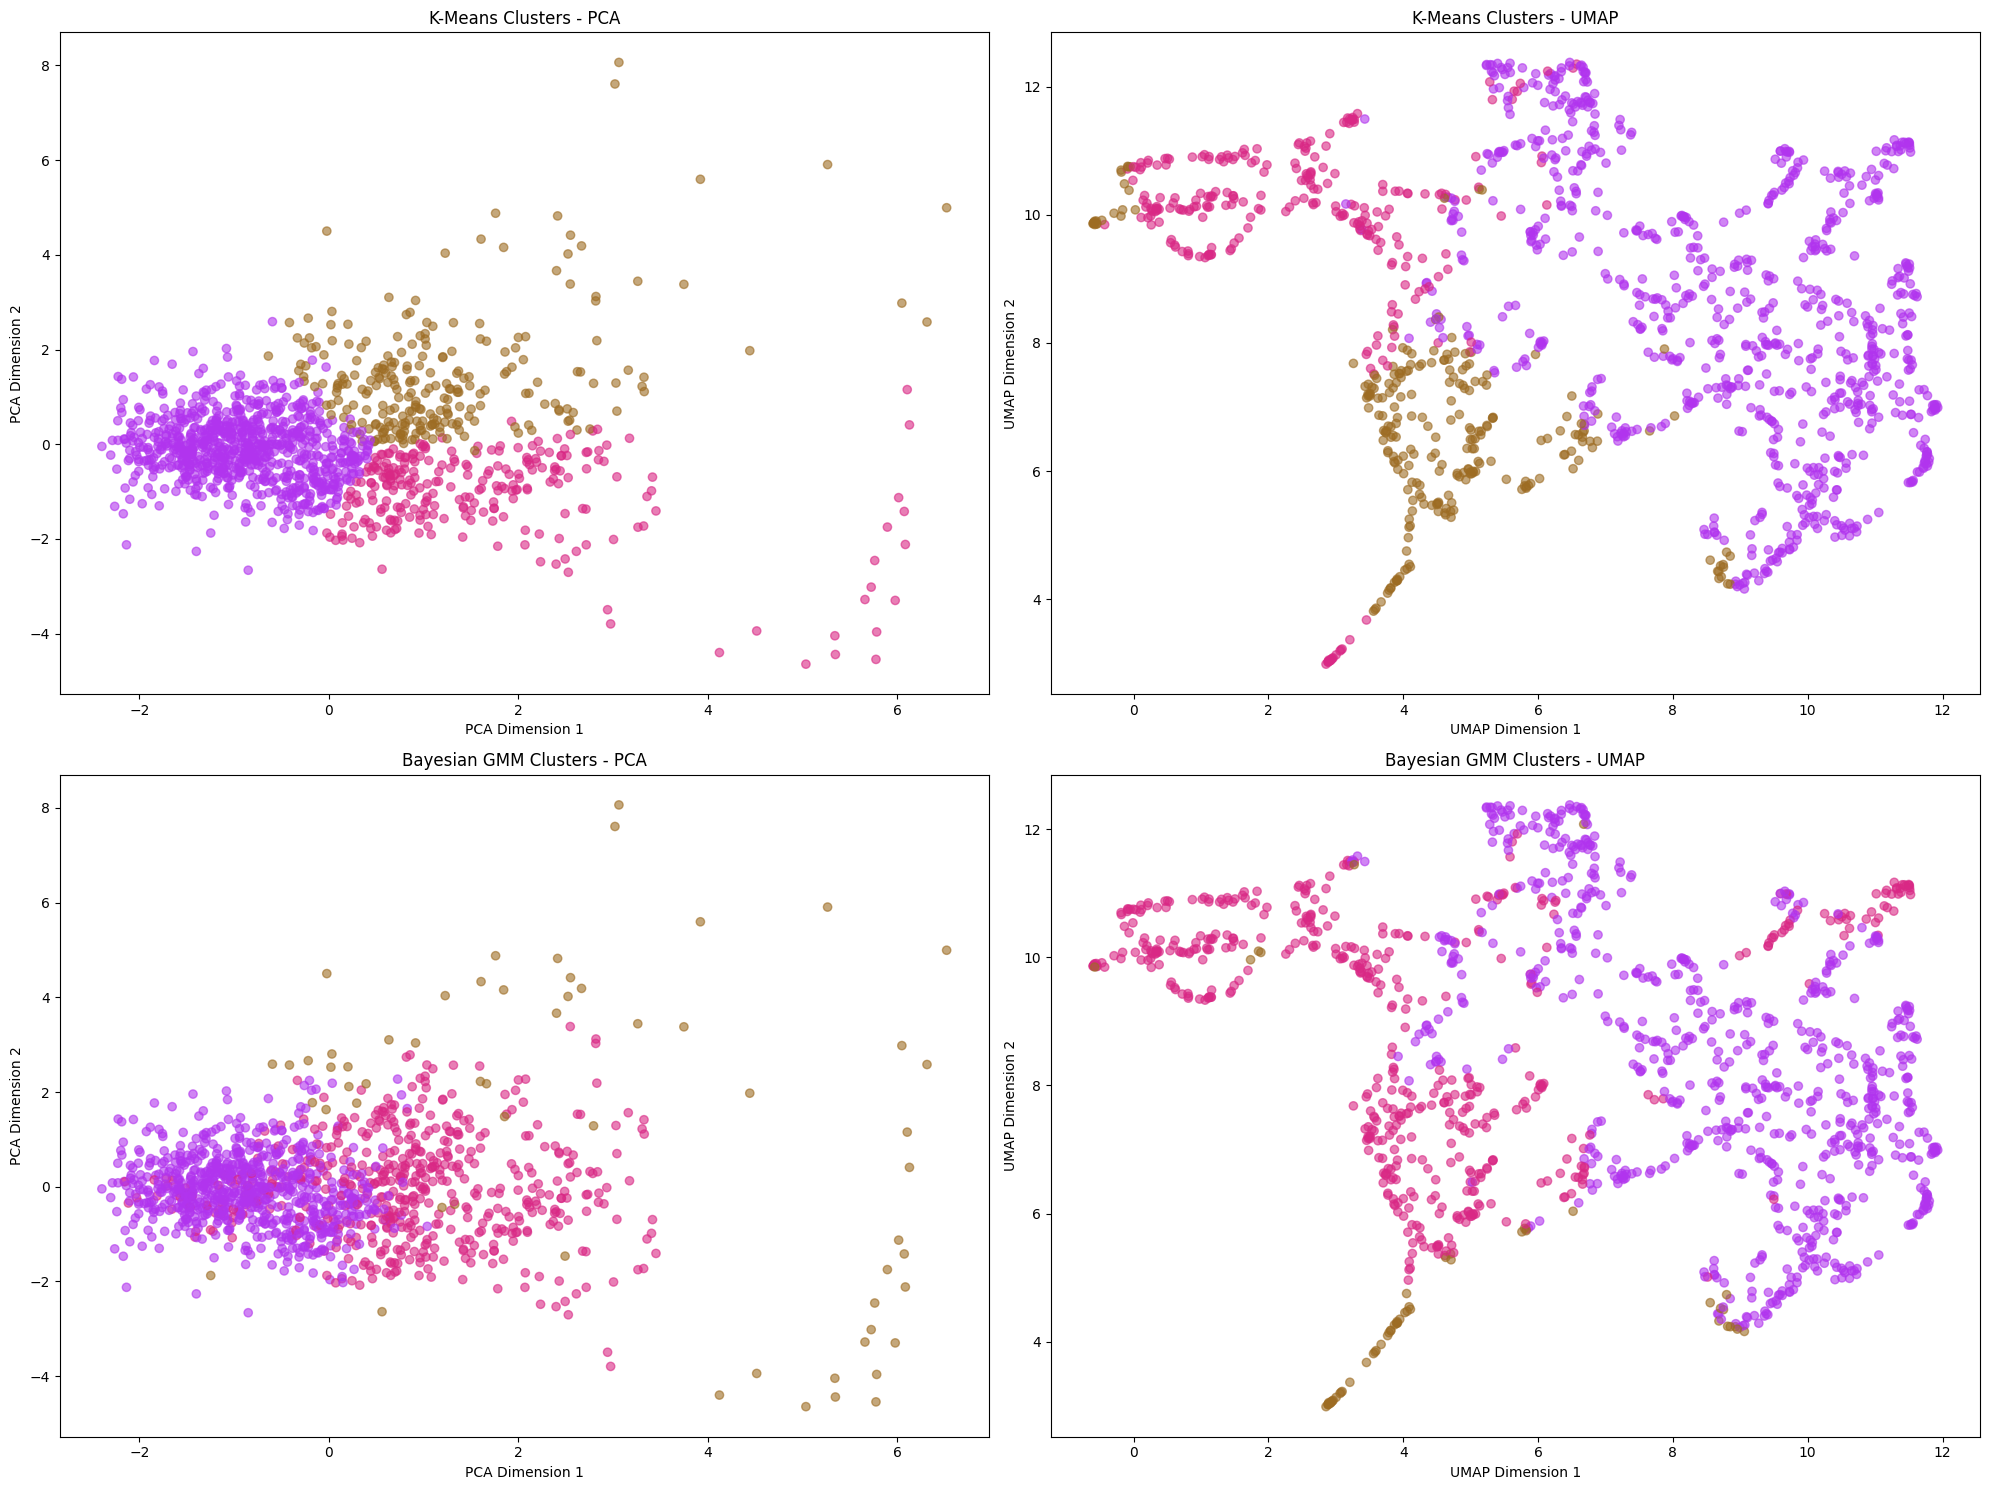

In [78]:
# K-Means labels
kmeans_labels = kmeans.fit_predict(scaled_features)
bgmm_labels = bgmm.fit_predict(scaled_features)

# Dimensionality Reduction Techniques
techniques = {
    'PCA': PCA(n_components=2),
    'UMAP': umap.UMAP(n_components=2, random_state=42)
}

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Palette
palette = sns.husl_palette(l=.5, h=.8)

# Iterate through clustering methods and dimensionality reduction techniques
for i, (method_name, method_labels) in enumerate(
    [('K-Means', kmeans_labels), ('Bayesian GMM', bgmm_labels)]
):
    for j, (technique_name, reducer) in enumerate(techniques.items()):
        # Reduce dimensionality
        reduced_features = reducer.fit_transform(scaled_features)
        
        # Plot
        ax = axes[i, j]
        scatter = ax.scatter(
            reduced_features[:, 0], 
            reduced_features[:, 1],
            c=[palette[label] for label in method_labels],
            alpha=0.6
        )
        
        ax.set_title(f'{method_name} Clusters - {technique_name}')
        ax.set_xlabel(f'{technique_name} Dimension 1')
        ax.set_ylabel(f'{technique_name} Dimension 2')

plt.tight_layout()
plt.show()


C:\Users\james\AppData\Local\Temp\ipykernel_11884\240571366.py:15: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.scatterplot(
C:\Users\james\AppData\Local\Temp\ipykernel_11884\240571366.py:30: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.scatterplot(


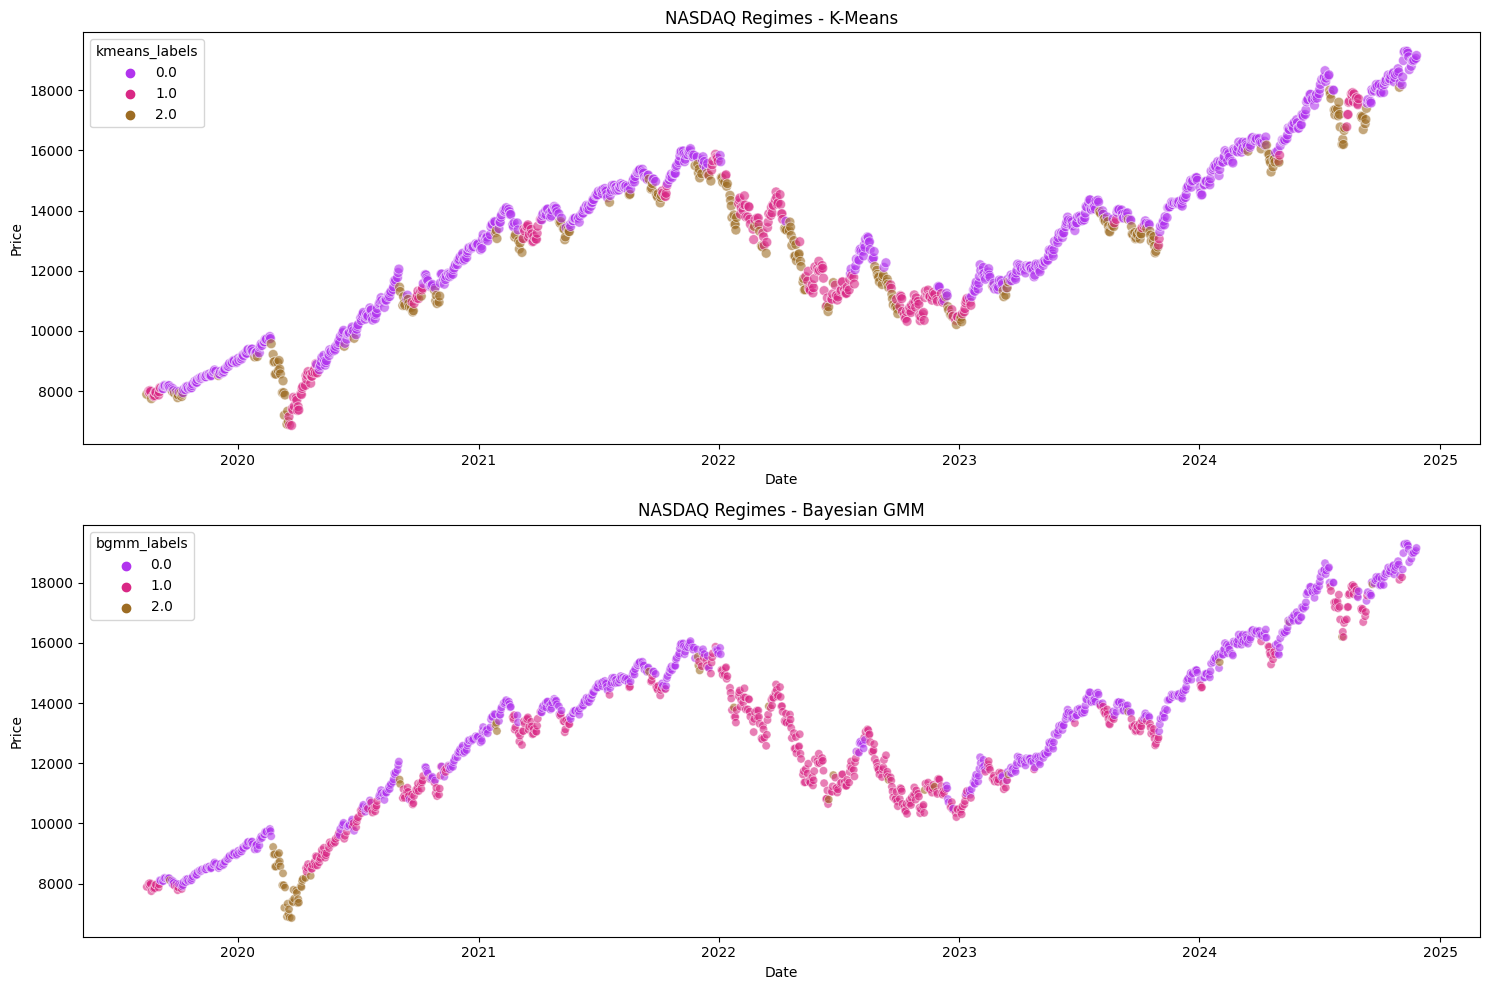

In [79]:
# Ensure that we are assigning the labels only to the rows that were used for clustering
valid_index = features.dropna().index  # Get the valid indices from the features DataFrame

# Initialize the columns with NaN values to match the size of df
df['kmeans_labels'] = np.nan
df['bgmm_labels'] = np.nan

# Assign the labels back to the valid indices (those that were used for clustering)
df.loc[valid_index, 'kmeans_labels'] = kmeans_labels
df.loc[valid_index, 'bgmm_labels'] = bgmm_labels

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# K-Means Regimes Plot
sns.scatterplot(
    x=df.loc[valid_index].index,  # Ensure using the valid indices
    y=df.loc[valid_index, 'close'],  # Align 'close' values with valid indices
    hue=df.loc[valid_index, 'kmeans_labels'],  # Use valid labels
    palette=palette,
    alpha=0.6,
    s=50,
    ax=ax1
)

ax1.set_title('NASDAQ Regimes - K-Means')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')

# Bayesian GMM Regimes Plot
sns.scatterplot(
    x=df.loc[valid_index].index,  # Ensure using the valid indices
    y=df.loc[valid_index, 'close'],  # Align 'close' values with valid indices
    hue=df.loc[valid_index, 'bgmm_labels'],  # Use valid labels
    palette=palette,
    alpha=0.6,
    ax=ax2
)

ax2.set_title('NASDAQ Regimes - Bayesian GMM')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price')

plt.tight_layout()
plt.show()

C:\Users\james\AppData\Local\Temp\ipykernel_11884\3166631896.py:5: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.scatterplot(
C:\Users\james\AppData\Local\Temp\ipykernel_11884\3166631896.py:20: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.scatterplot(


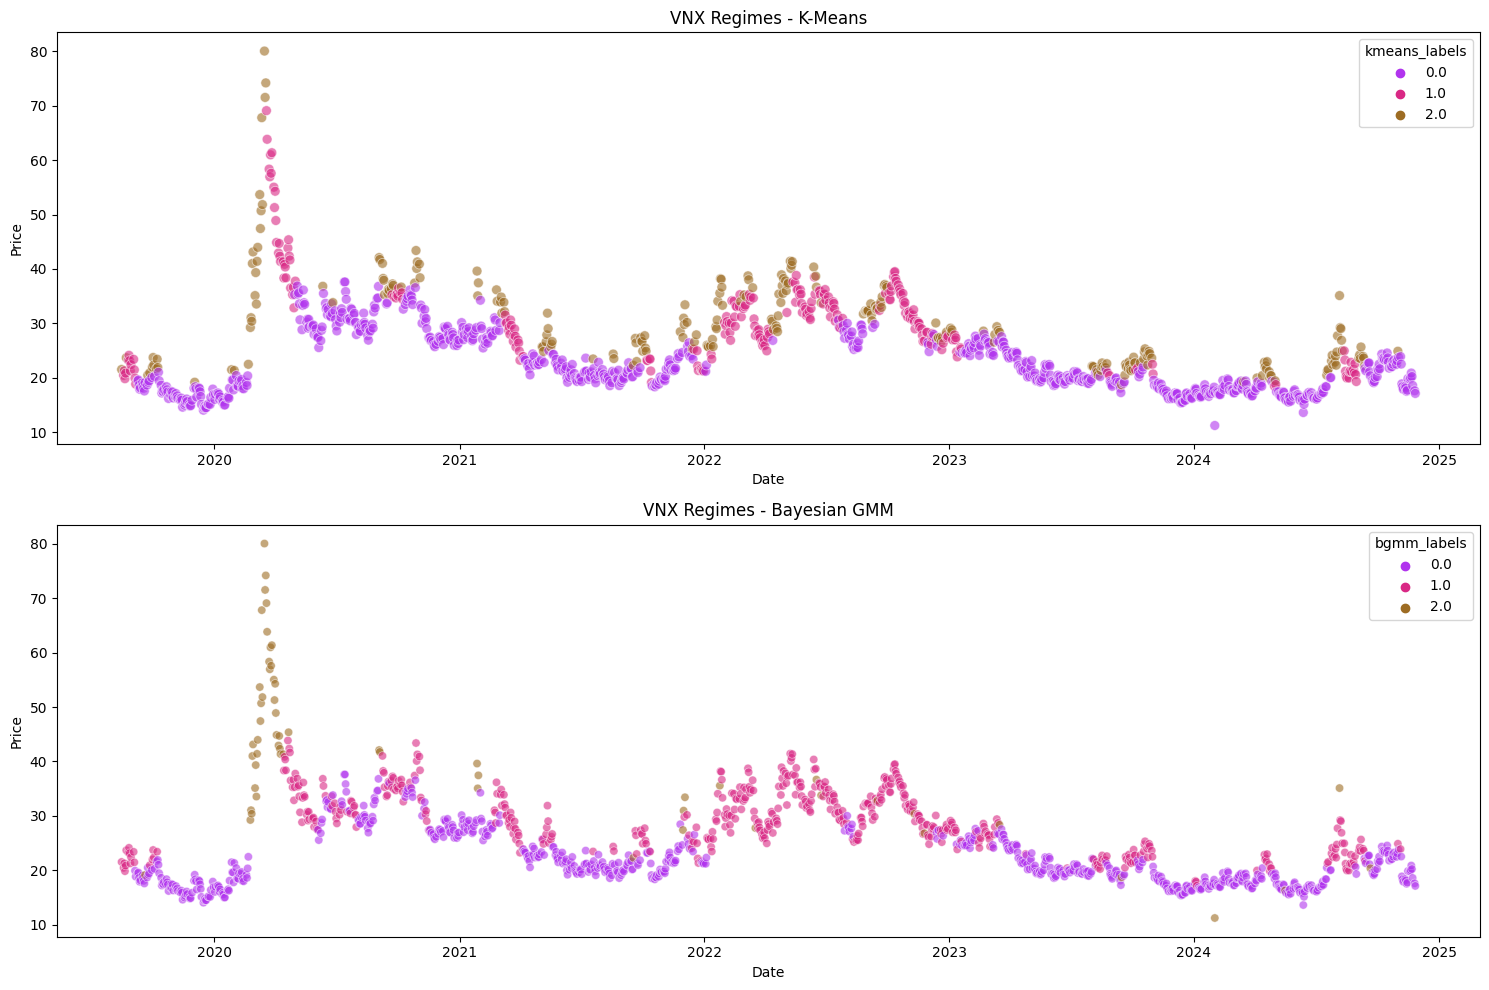

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# K-Means Regimes Plot
sns.scatterplot(
    x=df.loc[valid_index].index,  # Ensure using the valid indices
    y=df.loc[valid_index, 'vxn'],  # Align 'close' values with valid indices
    hue=df.loc[valid_index, 'kmeans_labels'],  # Use valid labels
    palette=palette,
    alpha=0.6,
    s=50,
    ax=ax1
)

ax1.set_title('VNX Regimes - K-Means')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')

# Bayesian GMM Regimes Plot
sns.scatterplot(
    x=df.loc[valid_index].index,  # Ensure using the valid indices
    y=df.loc[valid_index, 'vxn'],  # Align 'close' values with valid indices
    hue=df.loc[valid_index, 'bgmm_labels'],  # Use valid labels
    palette=palette,
    alpha=0.6,
    ax=ax2
)

ax2.set_title('VNX Regimes - Bayesian GMM')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price')

plt.tight_layout()
plt.show()

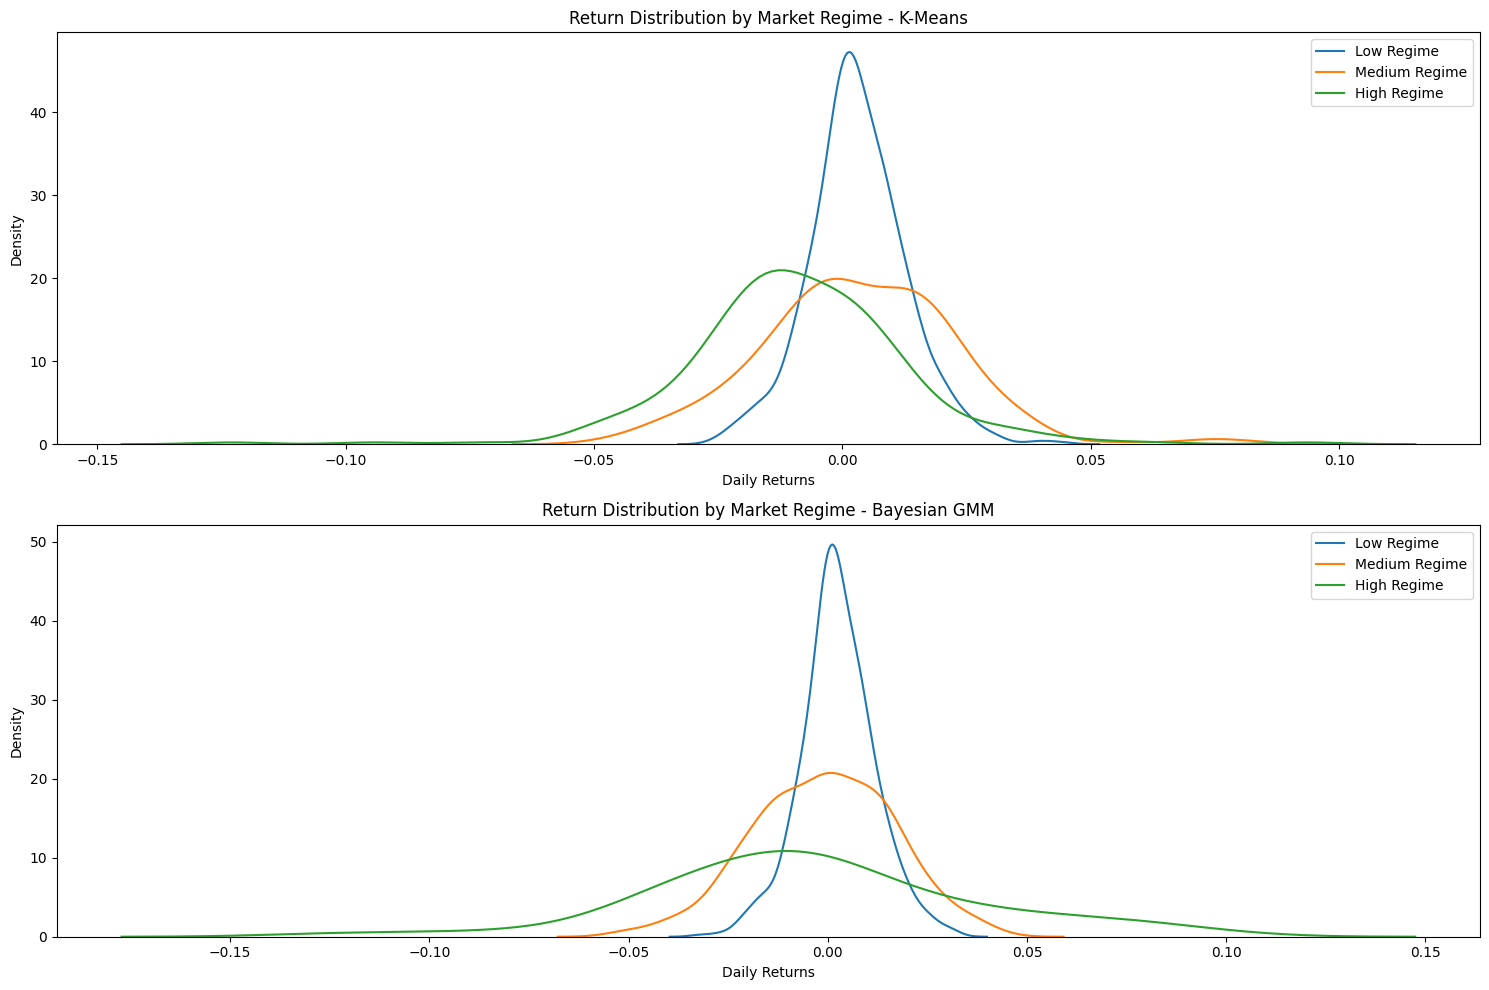

In [90]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# K-Means Distribution Plot
for regime in set(kmeans_labels):
    mask_kmeans = df['kmeans_labels'] == regime
    sns.kdeplot(
        data=df[mask_kmeans]['returns'],
        label=regime,
        ax=ax1
    )

ax1.set_title('Return Distribution by Market Regime - K-Means')
ax1.set_xlabel('Daily Returns')
ax1.legend(["Low Regime", "Medium Regime", "High Regime"])

# Bayesian GMM Distribution Plot
for regime in set(kmeans_labels):
    mask_bgmm = df['bgmm_labels'] == regime
    sns.kdeplot(
        data=df[mask_bgmm]['returns'],
        label=regime, 
        ax=ax2
    )

ax2.set_title('Return Distribution by Market Regime - Bayesian GMM')
ax2.set_xlabel('Daily Returns')
ax2.legend(["Low Regime", "Medium Regime", "High Regime"])

plt.tight_layout()
plt.show()